In [1]:
from __future__ import print_function
import steps.model as smodel
import steps.solver as ssolver
import steps.geom as swm
import steps.rng as srng
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as itp

from parameters import *
from misc import *
from components import *

### Loading vdcc_dat for given ISI

In [2]:
isi=20
loc="/home/kabir/Project/tripartiteSynapse/mcell"
VDCC_rates={
'VDCC_C01' : np.loadtxt(loc+"/vdcc_dat/VDCC_PQ_C01_" + str(isi) + "ms_ppf.dat"),
'VDCC_C12' : np.loadtxt(loc+"/vdcc_dat/VDCC_PQ_C12_" + str(isi) + "ms_ppf.dat"),
'VDCC_C23' : np.loadtxt(loc+"/vdcc_dat/VDCC_PQ_C23_" + str(isi) + "ms_ppf.dat"),
'VDCC_C3O' : np.loadtxt(loc+"/vdcc_dat/VDCC_PQ_C34_" + str(isi) + "ms_ppf.dat"),
'VDCC_OC3' : np.loadtxt(loc+"/vdcc_dat/VDCC_PQ_C43_" + str(isi) + "ms_ppf.dat"),
'VDCC_C32' : np.loadtxt(loc+"/vdcc_dat/VDCC_PQ_C32_" + str(isi) + "ms_ppf.dat"),
'VDCC_C21' : np.loadtxt(loc+"/vdcc_dat/VDCC_PQ_C21_" + str(isi) + "ms_ppf.dat"),
'VDCC_C10' : np.loadtxt(loc+"/vdcc_dat/VDCC_PQ_C10_" + str(isi) + "ms_ppf.dat"),
'VDCCflux'  : np.loadtxt(loc+"/vdcc_dat/VDCC_PQ_Ca_"  + str(isi) + "ms_ppf.dat")} 

#fitting cubic splines
VDCC_spline={}
for key in VDCC_rates.keys():
    VDCC_spline[key]=itp.interp1d(VDCC_rates[key].T[0],VDCC_rates[key].T[1],kind='cubic')

In [3]:
#plt.figure(figsize=(20,10))
#VDCC_spline[key](0)
#plt.scatter(VDCC_rates['VDCC_C3O'].T[0],VDCC_rates['VDCC_C3O'].T[1])
#x=np.linspace(0,0.025,10000)
#plt.plot(x,VDCC_spline['VDCC_C3O'](x))
#float(itp.splev(1,VDCC_spline['VDCC_C30'],der=0))

In [4]:
mParts = ['vdcc']#, 'az', 'cb', 'pmca', 'ryr']

mdl = smodel.Model()
cytvsys = smodel.Volsys('cytvsys', mdl)
cytssys = smodel.Surfsys('cytSurfsys', mdl)

#ervsys = smodel.Volsys('ervsys', mdl)
#erssys = smodel.Surfsys('erSurfsys', mdl)

Ca = smodel.Spec('Ca', mdl)

if 'cb'    in mParts: cbMol,    R_cb    = get_cb(cytvsys, mdl, Ca)
if 'pmca'  in mParts: pmcaMol,  R_PMCA  = get_PMCA(cytssys, mdl, Ca)
if 'vdcc'  in mParts: vdccMol,  R_VDCC  = get_VDCC(cytssys, mdl, Ca)
if 'az'    in mParts: azMol,    R_AZ    = get_AZ(cytssys, mdl, Ca)
if 'serca' in mParts: sercaMol, R_SERCA = get_SERCA(erssys, mdl, Ca)
if 'ryr'   in mParts: ryrMol,   R_RyR   = get_RyR(erssys, mdl, Ca)

In [5]:
wmgeom = swm.Geom()

# Create the cytosol compartment
cytVol = swm.Comp('cytVol', wmgeom, vol=cytVolVal) # cyt vol = 1 - ER vol = 0.961 um^3
cytVol.addVolsys('cytvsys')

# cyt is the 'inner' compartment, no outer compartment
cytSurf = swm.Patch('cytSurf', wmgeom, cytVol, area=cytArea) # cyt surf area = 8.5 um^2
cytSurf.addSurfsys('cytSurfsys')

# Create the Endoplasmic Reticulum compartment
#erVol = swm.Comp('erVol', wmgeom, vol=erVolVal) # ER vol = 0.039 um^3
#erVol.addVolsys('ervsys')

# # ER is the 'inner' compartment, cyt is the 'outer' compartment
#erSurfVDCC_spline.keys() = swm.Patch('erSurf', wmgeom, erVol, cytVol, area=erArea) # ER surf area = 1.58 um^2
#erSurf.addSurfsys('erSurfsys')

#print('Inner compartment to cytSurf is', erSurf.getIComp().getID())
#print('Outer compartment to cytSurf  is', erSurf.getOComp().getID())

r = srng.create('mt19937', 256)
r.initialize(23411)

sim = ssolver.Wmdirect(mdl, wmgeom, r)
sim.reset()

In [6]:
r = srng.create('mt19937', 256)
r.initialize(23412)

In [7]:
sim = ssolver.Wmdirect(mdl, wmgeom, r)

In [8]:
#NITER = 100
#res = numpy.zeros([NITER, 2001, 3])


sim.reset()

### Simulation time
ti, tf, dt = 0.0, 25.0e-3, 1e-5
T = np.arange(ti, tf+dt, dt)
npts = len(T)

### Set initial conditions
sim.setCompConc('cytVol', 'Ca', 1e-4) #initV['Ca'][0])

if 'cb' in mParts: 
    for mol,ic in zip(cbMolName,initV['cb']):
        sim.setCompConc('cytVol', mol, ic)
    
if 'pmca' in mParts: 
    for mol,ic in zip(pmcaMolName,initV['PMCA']):
        num = round(ic*8.5)
        sim.setPatchCount('cytSurf', mol, num)
    
if 'vdcc' in mParts: 
    sim.setPatchCount('cytSurf', 'VDCC_C0', 80)

if 'az' in mParts: 
    sim.setPatchCount('cytSurf', 'AZ00', 7)
    
if 'ryr' in mParts: 
    sim.setPatchCount('erSurf', 'RyRLC1', 150)


### result container
resCa = np.zeros([npts])
if 'cb'   in mParts: rescb   = np.zeros([npts, len(cbMolName)])
if 'pmca' in mParts: resPMCA = np.zeros([npts, len(pmcaMolName)])
if 'vdcc' in mParts: resVDCC = np.zeros([npts, len(vdccMolName)])
if 'az'   in mParts: resAZ   = np.zeros([npts, len(azMolName)])
if 'ryr'  in mParts: resRyR  = np.zeros([npts, len(ryrMolName)])

Ti = time()
for t in range(npts):
    ##Updating VDCC rates
    for key in R_VDCC.keys():
        #R_VDCC[key].kcst=float(itp.splev(T[t],VDCC_spline[key],der=0))
        R_VDCC[key].kcst=float(VDCC_spline[key](T[t]))
    
    sim.run(T[t])
    
    resCa[t] = sim.getCompCount('cytVol', 'Ca')
    
    if 'cb' in mParts: 
        for i,mol in enumerate(cbMolName):
            rescb[t,i] = sim.getCompCount('cytVol', mol)
        
    if 'pmca' in mParts: 
        for i,mol in enumerate(pmcaMolName):
            resPMCA[t,i] = sim.getPatchCount('cytSurf', mol)

    if 'vdcc' in mParts: 
        for i,mol in enumerate(vdccMolName):
            resVDCC[t,i] = sim.getPatchCount('cytSurf', mol)
    
    if 'az' in mParts: 
        for i,mol in enumerate(azMolName):
            resAZ[t,i] = sim.getPatchCount('cytSurf', mol)
            
    if 'ryr' in mParts: 
        for i,mol in enumerate(ryrMolName):
            resRyR[t,i] = sim.getPatchCount('erSurf', mol)
    
Tf = time()
print(Tf-Ti, 'sec')

1.106961965560913 sec


## Plots

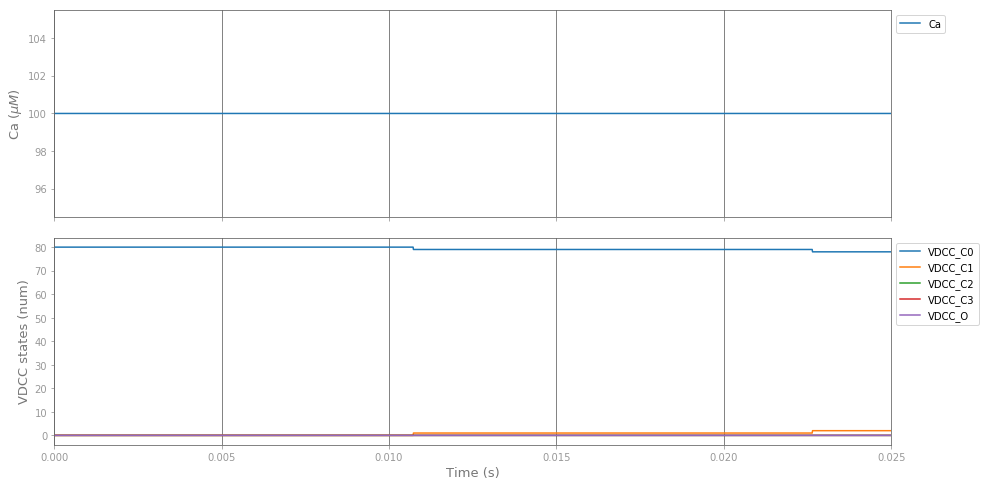

In [9]:
nFig = 1 + len(mParts)
figure, ax = plt.subplots(nFig, figsize=(15, 4*nFig), sharex=True)
figure.subplots_adjust(hspace=0.1)
labelfontsize = 13

j = 0
ax[j].plot(T, resCa/NA/cytVolVal*1e3, label='Ca')
ax[j].set_ylabel(r'Ca ($\mu M$)', fontsize=labelfontsize)

j += 1
if 'cb' in mParts: 
    for i,mol in enumerate(cbMolName):
        ax[j].plot(T, rescb[:,i], label=mol)
    ax[j].set_ylabel('Calbindin states (num)', fontsize=labelfontsize)
    j += 1

if 'pmca' in mParts:
    for i,mol in enumerate(pmcaMolName):
        ax[j].plot(T, resPMCA[:,i], label=mol)
    ax[j].set_ylabel('PMCA states (num)', fontsize=labelfontsize)
    j += 1

if 'vdcc' in mParts: 
    for i,mol in enumerate(vdccMolName):
        ax[j].plot(T, resVDCC[:,i], label=mol)
    ax[j].set_ylabel('VDCC states (num)', fontsize=labelfontsize)
    j += 1

if 'az' in mParts:
    for mol in [azMolName[i] for i in [0,5,11,12,13,14,15,16,17]]:
        i = azMolName.index(mol)
        ax[j].plot(T, resAZ[:,i], label=mol)
    ax[j].set_ylabel('AZ states (num)', fontsize=labelfontsize)
    j += 1
    
if 'ryr' in mParts:
    for i,mol in enumerate(ryrMolName):
        ax[j].plot(T, resRyR[:,i], label=mol)
    ax[j].set_ylabel('RyR states (num)', fontsize=labelfontsize)
    j += 1

ax[-1].set_xlabel('Time (s)', fontsize=labelfontsize)

facecol = '#ffffff11'
labelcol = '#777777'
tickcol = '#999999'
spinecol = '#666666'
for x in ax:
    x.legend(loc='upper left', facecolor='white', framealpha=0.8, bbox_to_anchor=(1,1))
    
    x.set_xlim(min(T), max(T))
    
    x.spines['bottom'].set_color(spinecol)
    x.spines['top'].set_color(spinecol)
    x.spines['right'].set_color(spinecol)
    x.spines['left'].set_color(spinecol)
    
    x.xaxis.label.set_color(labelcol)
    x.yaxis.label.set_color(labelcol)
    
    x.tick_params(axis='x', colors=tickcol)
    x.tick_params(axis='y', colors=tickcol)
    
    x.set_facecolor(facecol)#'xkcd:salmon')
    
    x.grid(axis='x', color=spinecol)
    
#plt.savefig('test.eps', dpi=300, format='eps', transparent=True, bbox_inches=None, pad_inches=0.1)
#plt.show()